# Who Wants To Live Forever?

This notebook generates figures I used in a talk, "Who wants to live forever? Reliability Engineering and Mortality", presented at ODSC East 2024.

It is based on the datasets and analysis in *Probably Overthinking It*, Chapter 5, "Better than New".

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ProbablyOverthinkingIt/blob/book/examples/survival.ipynb).

In [1]:
# Install empiricaldist if we don't already have it

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [2]:
# download utils.py

from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download(
    "https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/notebooks/utils.py"
)

In [3]:
DATA_PATH = "https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/data/"

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.1)
sns.set(rc={'figure.figsize':(6, 3.5)})
sns.set_style('white')
plt.rcParams['axes.titlelocation'] = 'left'

# Set the random seed so we get the same results every time
np.random.seed(17)

In [5]:
import utils

def decorate(**options):
    utils.decorate(**options)
    sns.despine(left=True, bottom=True)

In [6]:
def savefig(filename, **options):
    if 'dpi' not in options:
        options['dpi'] = 300
    plt.savefig(filename, **options)

## Light Bulbs

The first example in the talk is based on the lifetimes of lightbulbs.
The data are available in a gist:

In [7]:
download(
    "https://gist.github.com/epogrebnyak/7933e16c0ad215742c4c104be4fbdeb1/raw/c932bc5b6aa6317770c4cbf43eb591511fec08f9/lamps.csv"
)

In [8]:
df = pd.read_csv("lamps.csv", index_col=0).drop(index=0)
df.head()

,h,f,K
i,,,
1,840,2,48
2,852,1,47
3,936,1,46
4,960,1,45
5,972,1,44


The `h` column contains the quantities; the `f` column contains the frequencies (counts), so we can put them in a `Pmf` object like this.

In [9]:
from empiricaldist import Pmf

pmf_lifetimes = Pmf(df["f"].values, index=df["h"])

Here's what it looks like with unnormalized counts.

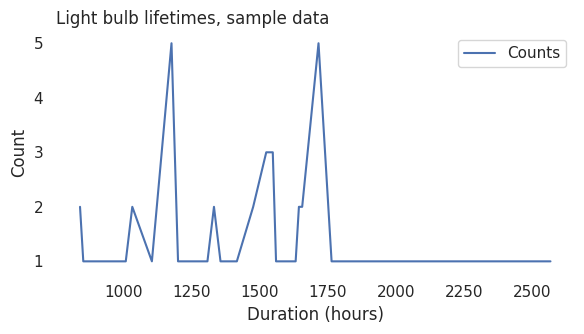

In [10]:
pmf_lifetimes.plot(color='C0', label='Counts')
decorate(xlabel='Duration (hours)',
         ylabel='Count',
         title='Light bulb lifetimes, sample data')
savefig('survival00.png')

And here's what it looks like as a normalized PMF.

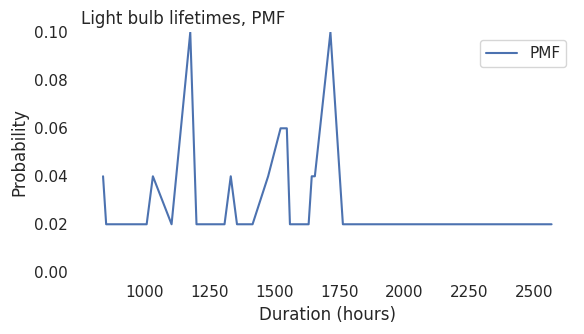

In [11]:
pmf_lifetimes.normalize()

pmf_lifetimes.plot(color='C0', label='PMF')
decorate(xlabel='Duration (hours)',
         ylabel='Probability',
         ylim=[0, 0.1],
         title='Light bulb lifetimes, PMF')
savefig('survival01.png')

The CDF is the cumulative sum of the PMF.

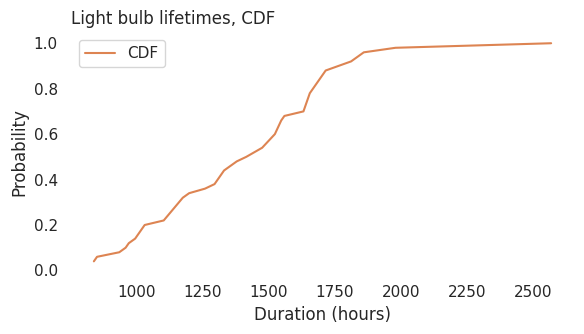

In [12]:
cdf_lifetimes = pmf_lifetimes.make_cdf()

cdf_lifetimes.plot(color='C1', label='CDF')
decorate(xlabel='Duration (hours)',
         ylabel='Probability',
         title='Light bulb lifetimes, CDF')
savefig('survival02.png')

And the survival curve is the complement of the CDF.

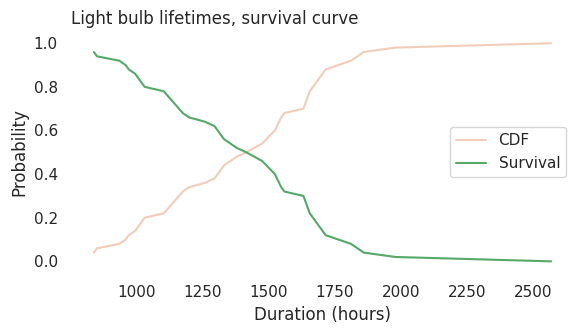

In [13]:
surv_lifetimes = cdf_lifetimes.make_surv()

cdf_lifetimes.plot(color='C1', label='CDF', alpha=0.4)
surv_lifetimes.plot(color='C2', label='Survival')
decorate(xlabel='Duration (hours)',
         ylabel='Probability',
         title='Light bulb lifetimes, survival curve')
savefig('survival03.png')

The hazard function is the conditional probability that a light bulb fails at time `t`, given that it has survived until time `t`.

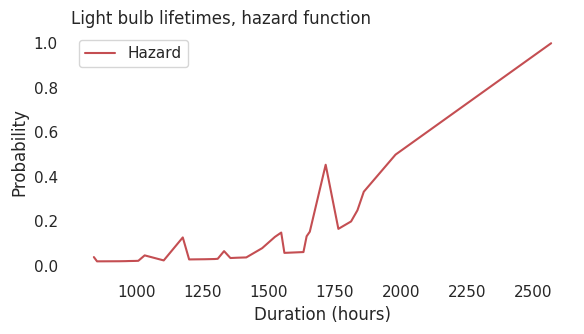

In [14]:
hazard_lifetimes = surv_lifetimes.make_hazard()

hazard_lifetimes.plot(color='C3', label='Hazard')
decorate(xlabel='Duration (hours)',
         ylabel='Probability',
         title='Light bulb lifetimes, hazard function')
savefig('survival04.png')

Plotting the hazard function can be misleading -- by plotting the cumulative hazard, we can get a better sense of how it varies over time.

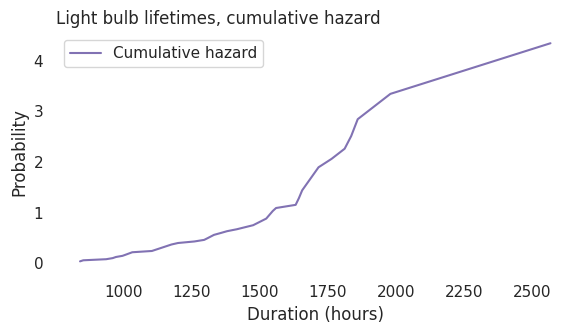

In [15]:
cumulative_hazard = hazard_lifetimes.cumsum()
cumulative_hazard.plot(color='C4', label='Cumulative hazard')

decorate(xlabel='Duration (hours)',
         ylabel='Probability',
         title='Light bulb lifetimes, cumulative hazard')
savefig('survival05.png')

Where the cumulative hazard curve is steep, the instantaneous hazard is high.
So light bulbs are in the most danger around 1800 hours.

These steps are reversible -- given any of these representations, we can compute the others.

In [16]:
pmf_lifetimes2 = hazard_lifetimes.make_pmf()
np.allclose(pmf_lifetimes, pmf_lifetimes2)

True

## Cancer survival times


NOTE: I am definitely not allowed to redistribute SEER data, so the data in this example in synthetic -- that is, I have generated random data that is statistically similar to the actual data I reported in the book. The results below will differ from what's in the book, but the conclusions are qualitatively similar.

In [17]:
filename = "brain.hdf"
download(DATA_PATH + filename)

In [18]:
brain = pd.read_hdf("brain.hdf", "brain")
brain.shape

(16202, 2)

In [19]:
brain.head()

,duration,observed
0,4.50,True
1,15.75,True
2,10.75,True
3,6.25,True
4,29.50,True


From the SEER data I selected the 16,202 cases of glioblastoma, diagnosed between 2000 and 2016, where the survival times are available.
We can use this data to infer the distribution of survival times, but first we have to deal with a statistical obstacle: some of the patients are still alive, or were alive the last time they appeared in a registry.

For these cases, the time until their death is unknown (which is a good thing!).
However, in order to work with data like this, we need a special method, called Kaplan-Meier estimation, to compute the distribution of lifetimes.

`duration` is the observed duration in months, for both complete and ongoing cases.

In [20]:
duration = brain["duration"]
duration.describe()

count    16202.000000
mean        13.457783
std         19.088951
min          0.250000
25%          3.250000
50%          7.750000
75%         16.500000
max        201.750000
Name: duration, dtype: float64

`observed` is a Boolean Series that indicates whether each case is complete or ongoing.

In [21]:
observed = brain["observed"]
observed.sum()

14548

`lifelines` is a high-quality Python package that provides many functions related to survival analysis, including Kaplan-Meier estimation.

In [ ]:
try:
    import lifelines
except ImportError:
    !pip install lifelines

In [22]:
import lifelines
from empiricaldist import Surv

fit = lifelines.KaplanMeierFitter().fit(duration, observed)
surv_km_lifelines = Surv(fit.survival_function_["KM_estimate"])

But if you are curious about the details, here's an implementation of the same method using `Pmf` and `Surv` objects from `empiricaldist`.

In [23]:
from empiricaldist import Hazard

def estimate_hazard(duration, observe):
    """Kaplan-Meier estimation using empiricaldist
    
    duration: Series of durations
    observed: Boolean Series, True if complete, False if censored
    
    returns: Hazard
    """
    # separate complete and ongoing cases
    complete = duration[observed]
    ongoing = duration[~observed]

    # compute unnormalize PMFs of complete, incomplete, and all cases
    pmf_complete = Pmf.from_seq(complete, normalize=False)
    pmf_ongoing = Pmf.from_seq(ongoing, normalize=False)
    pmf_all = pmf_complete + pmf_ongoing

    # also compute the survival functions
    surv_complete = pmf_complete.make_surv()(pmf_all.index)
    surv_ongoing = pmf_ongoing.make_surv()(pmf_all.index)

    # the denominator is every case that is "at risk" at time `t`
    at_risk = pmf_all + surv_complete + surv_ongoing

    # the hazard is the fraction of "at risk" that complete at time `t`
    hazard_km = Hazard(pmf_complete / at_risk)
    return hazard_km

The result from `estimate_hazard` is the hazard function, which we can use to compute a survival function.

In [24]:
hazard_km = estimate_hazard(duration, observed)
surv_km = hazard_km.make_surv()

And we can confirm that the results from `lifelines` are the same -- with the exception that `lifelines` includes a point at `t=0`.
`empiricaldist` does not, in order to maintain the invariant that all representations of a distribution have the same index, which is the set of unique observed quantities.

In [25]:
np.allclose(surv_km, surv_km_lifelines.drop(0))

True

Here's what the hazard function looks like.
As usual, it's too noisy to really see what's going on.

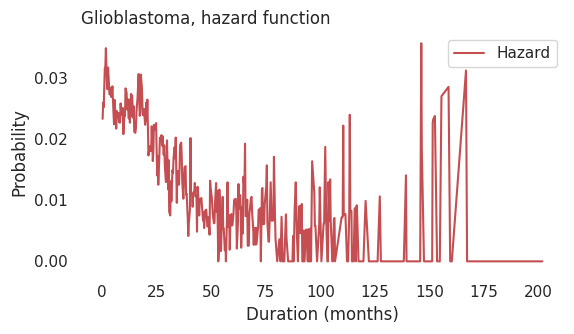

In [26]:
hazard_km.plot(color='C3', label='Hazard')

decorate(xlabel='Duration (months)',
         ylabel='Probability',
         title='Glioblastoma, hazard function')
savefig('survival06.png')

The cumulative hazard curve gives a clearer picture.

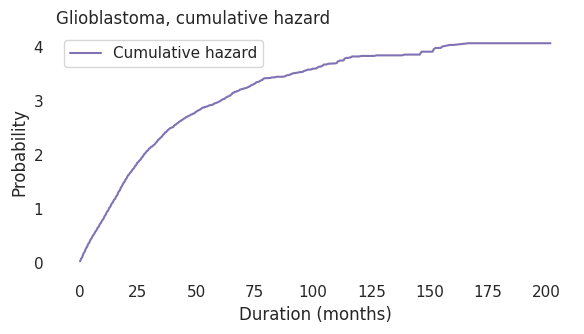

In [27]:
cumulative_hazard_km = hazard_km.cumsum()
cumulative_hazard_km.plot(color='C4', label='Cumulative hazard')

decorate(xlabel='Duration (months)',
         ylabel='Probability',
         title='Glioblastoma, cumulative hazard')
savefig('survival07.png')

The cumulative hazard is steepest immediately after diagnosis, which means the instantaneous hazard is highest.
After that, it decreases, which is good news.

From the survival curve, we can compute the CDF.

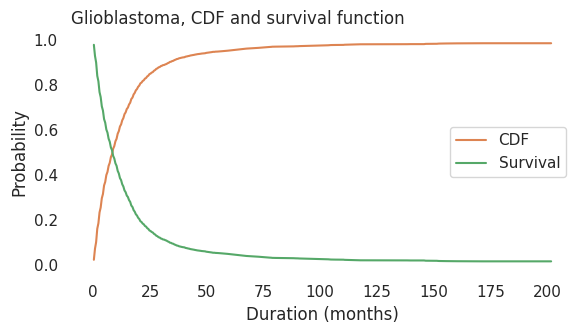

In [28]:
cdf_km = surv_km.make_cdf()
cdf_km.plot(color='C1', label='CDF')
surv_km.plot(color='C2', label='Survival')

decorate(xlabel='Duration (months)',
         ylabel='Probability',
         title='Glioblastoma, CDF and survival function')
savefig('survival08.png')

And from the CDF we can compute the PMF.

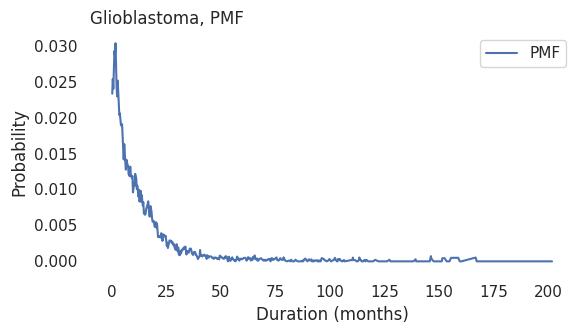

In [29]:
pmf_km = cdf_km.make_pmf()
pmf_km.plot(color='C0', label='PMF')

decorate(xlabel='Duration (months)',
         ylabel='Probability',
         title='Glioblastoma, PMF')
savefig('survival09.png')

This example shows how we can use Kaplan-Meier to estimate the hazard function, and from there we can compute the other representations of the distribution.

## Life Expectancy At Birth

The final example demonstrates a case where we are given the hazard function directly, and we can use it to compute the other representations.

In 2012, a team of demographers at the University of Southern California estimated life expectancy for people born in Sweden in the early 1800s and 1900s.
They chose Sweden because it "has the deepest historical record of high-quality [demographic] data."

For ages from 0 to 91 years, they estimated the mortality rate, which is the fraction of people at each age who die.
I used an online graph digitizer to get the data from the figure in their paper and store it in a CSV file.

In [30]:
filename = "mortality_rates_beltran2012.csv"
download(DATA_PATH + filename)

In [31]:
mortality = pd.read_csv(filename, header=[0, 1])
mortality.head()

1905                1800          
          X         Y         X         Y
0  0.056633 -2.685744  0.066515 -1.541222
1  0.175223 -2.866213  0.224635 -1.692583
2  0.293812 -3.043189  0.362990 -1.890516
3  0.412402 -3.216672  0.481580 -2.052938
4  0.530992 -3.390155  0.623887 -2.239811

In [32]:
def make_series(x, y):
    """Make a pandas Series.
    
    x: values for the index
    y: values of the series
    
    returns: Series
    """
    return pd.Series(y, x).dropna()

In [33]:
mort1800 = make_series(mortality["1800", "X"], mortality["1800", "Y"].values)
mort1800.head()

(1800, X)
0.066515   -1.541222
0.224635   -1.692583
0.362990   -1.890516
0.481580   -2.052938
0.623887   -2.239811
dtype: float64

In [34]:
mort1905 = make_series(mortality["1905", "X"], mortality["1905", "Y"].values)
mort1905.head()

(1905, X)
0.056633   -2.685744
0.175223   -2.866213
0.293812   -3.043189
0.412402   -3.216672
0.530992   -3.390155
dtype: float64

The following function interpolates the data from the figure and puts it in a `Hazard` object.

In [35]:
from scipy.interpolate import interp1d
from empiricaldist import Hazard


def make_hazard(series):
    """Make a Hazard function by interpolating a Series.
    
    series: Series
    
    returns: Hazard
    """
    interp = interp1d(series.index, series.values, fill_value="extrapolate")
    xs = np.arange(0, 108)
    ys = np.exp(interp(xs))
    return Hazard(ys, xs)

In [36]:
haz1800 = make_hazard(mort1800)
haz1905 = make_hazard(mort1905)


The following figure shows the results for two cohorts: people born between 1800 and 1810, and people born between 1905 and 1915.

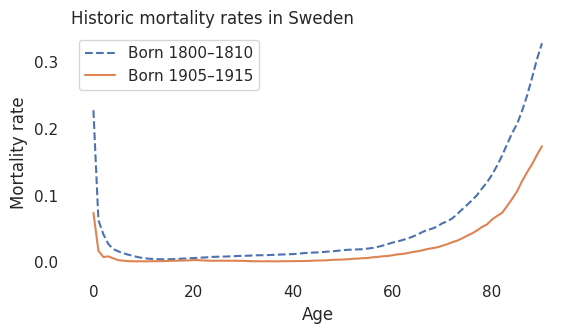

In [37]:
haz1800[:91].plot(label="Born 1800–1810", ls="--")
haz1905[:91].plot(label="Born 1905–1915")

decorate(
    xlabel="Age", ylabel="Mortality rate", title="Historic mortality rates in Sweden"
)
savefig('survival11.png')

From the hazard function, we can jump right to the `Pmf`.

In [38]:
pmf1800 = haz1800.make_pmf()
pmf1800.normalize()

0.9999999998644409

In [39]:
pmf1905 = haz1905.make_pmf()
pmf1905.normalize()

0.9999711879585407

Here's what the PMFs look like.

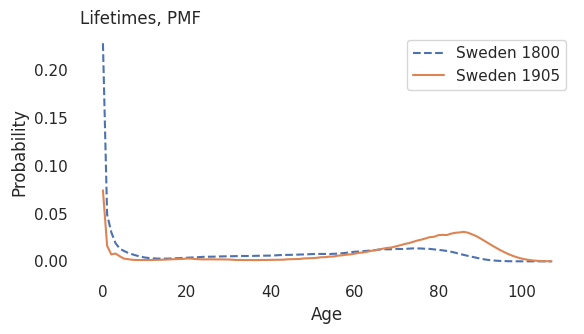

In [40]:
pmf1800.plot(ls="--", color="C0", label="Sweden 1800")
pmf1905.plot(ls="-", color="C1", label="Sweden 1905")

decorate(xlabel="Age",
         ylabel="Probability",
         title='Lifetimes, PMF')
savefig('survival12.png')

In this representation we can see that the biggest changes are in child mortality and in the fraction of people who survive into their eighties.

From the `Pmf`, we can compute average remaining lifetimes as a function of age.

In [41]:
def remaining_lifetimes_pmf(pmf, qs):
    """Compute remaining lifetimes from a PMF.

    pmf: Pmf
    qs: quantities

    returns: Series that maps from ages to average remaining lifetimes
    """
    series = pd.Series(index=qs, dtype=float)
    for q in qs:
        conditional = Pmf(pmf[pmf.qs >= q])
        conditional.normalize()
        series[q] = conditional.mean() - q

    return series

In [42]:
qs = np.arange(0, 91)
series1905 = remaining_lifetimes_pmf(pmf1905, qs)
series1800 = remaining_lifetimes_pmf(pmf1800, qs)

The following figure shows the results for people born in Sweden around 1800 and 1905.

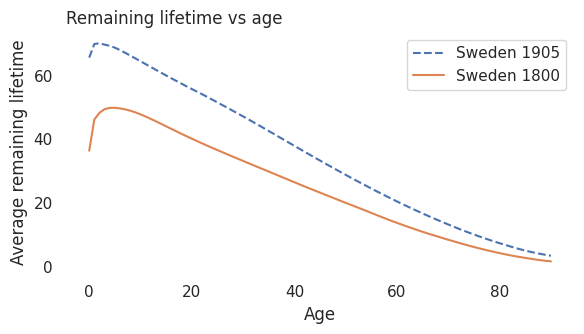

In [43]:
series1905.plot(ls="--", color="C0", label="Sweden 1905")
series1800.plot(ls="-", color="C1", label="Sweden 1800")

decorate(
    xlabel="Age", ylabel="Average remaining lifetime", title="Remaining lifetime vs age"
)
savefig('survival13.png')

We can see that people in these cohorts were UBNE at birth -- so their expected remaining lifetime increase during the first few years of life.

Probably Overthinking It

Copyright 2022 Allen Downey 

The code in this notebook and `utils.py` is under the [MIT license](https://mit-license.org/).